Missing values:
ID                       0
Date                     0
Supplier                 0
Origin                   0
Amount                   0
Money                    0
Containers               0
Quantity                 0
Total weight             0
Range                    0
VMM                      0
Belco SAS Stock Cover    0
All-stock coverage       0
CROP                     0
dtype: int64


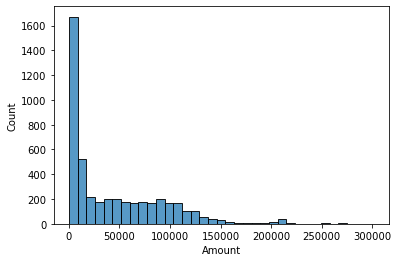

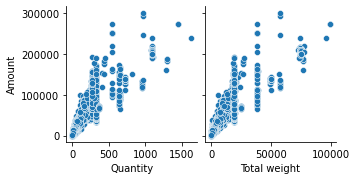

In [1]:
#step 1 - data_exploration
# data_exploration.ipynb
# to investigate and understand the DataSet -> handle missing values/outliers if any,and visualize the dataset relationships...
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def explore_data(dataset_path):
    df = pd.read_excel(dataset_path)

    #starting to print missing values in each column, so we can do preprocess if any
    print("Missing values:")
    print(df.isnull().sum())

    #draw a histogram of the Amount column
    sns.histplot(df['Amount'])
    plt.show()

    #scatter a matrix of 2 other columns(to compare with the Amount column)
    #we have 2 charts 1 for the Amount column alone with the count. and the other with Quantity and Total Weight column
    sns.pairplot(df, x_vars=['Quantity', 'Total weight'], y_vars='Amount', kind='scatter')
    plt.show()

if __name__ == "__main__":
    dataset_path = 'Data.xlsx'
    explore_data(dataset_path)


In [2]:
#step 2-> performing preprocessing (feature engineering)
import pandas as pd

def feature_engineering(df, exchange_rates):
    df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
    df['month'] = df['Date'].dt.month
    df['year'] = df['Date'].dt.year
    #one-hot encoding (converting catagorical values to numeric)
    df = pd.get_dummies(df, columns=['Supplier', 'Origin', 'Range'])
    #converting all currencies to USD
    df['Amount_USD'] = df.apply(lambda row: row['Amount'] * exchange_rates['EUR'] if row['Money'] == 'EUR' else row['Amount'], axis=1)
    df = df.drop(['Date','Amount', 'Money','ID','CROP'], axis=1) #we don't need those columns anymore
    return df

if __name__ == "__main__":
    df = pd.read_excel('Data.xlsx')
    #dictionary of exchange rate EUR/USD
    exchange_rates = {'EUR': 1.09,'USD': 1.0}
    df = feature_engineering(df, exchange_rates)
    #saving the preprocessed file to new file
    df.to_excel('preprocessed_data.xlsx', index=False)
    print("Preprocess completed successfully!")

Preprocess completed successfully!


In [4]:
#step 3- split the data into test and train set
#Training set (x_train, y_train) - 80%
#Validation set (x_val, y_val) - 10%
#test set (x_test, y_tste) - 10%
from sklearn.model_selection import train_test_split
import pandas as pd
 
def split_data(df):
    X = df.drop('Amount_USD', axis=1)
    y = df['Amount_USD']
    #split the data
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42) #20% of test_set will leave us 80% of training_set
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42) # we are taking 50% of the 20% for val_set
    
    return X_train, X_val, X_test, y_train, y_val, y_test

if __name__ == "__main__":
    df = pd.read_excel('preprocessed_data.xlsx')
    X_train, X_val, X_test, y_train, y_val, y_test = split_data(df)
    print("spliting completed successfully!")

spliting completed successfully!


In [5]:
#step 4- model training using randomforest algorithm
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import numpy as np

def train_model(X_train, y_train, X_val, y_val):
    param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]}
    grid_search = GridSearchCV(RandomForestRegressor(), param_grid, cv=5)
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_

    #evaluate the model on the validation
    y_val_pred = best_model.predict(X_val)
    #the model's predictions on the validation set
    print('Validation Mean Absolute Error:', mean_absolute_error(y_val, y_val_pred))
    #the average squared difference between the model's predictions and the actual values
    print('Validation Mean Squared Error:', mean_squared_error(y_val, y_val_pred))
    #how many variables are explained by the model
    print('Validation R-squared:', r2_score(y_val, y_val_pred))
    return best_model

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    #model's predictions on the test set
    print('Test Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
    #average squared difference between the model's predictions and the actual values
    print('Test Mean Squared Error:', mean_squared_error(y_test, y_pred))
    #% of variance in the target variable that the model uses
    print('Test R-squared:', r2_score(y_test, y_pred))

if __name__ == "__main__":
    df = pd.read_excel('preprocessed_data.xlsx')

    X_train, X_val, X_test, y_train, y_val, y_test = split_data(df)

    #train the model
    best_model = train_model(X_train, y_train, X_val, y_val)
    
    # Append predicted values to the DataFrame
    df['Amount_USD_Predicted'] = np.nan  # Initialize a new column for predicted values
    df.loc[X_val.index, 'Amount_USD_Predicted'] = best_model.predict(X_val)
    df.loc[X_test.index, 'Amount_USD_Predicted'] = best_model.predict(X_test)
    #we are storing the pridiction for test set and validation set(20%) because... 
    #predictions for the training set might not be informative because the model has already seen this data during training phase
    # Save the DataFrame with predicted values to a new Excel file
    df.to_excel('preprocessed_data_with_predictions.xlsx', index=False)

    #evaluate the model on the test set
    evaluate_model(best_model, X_test, y_test)

Validation Mean Absolute Error: 4311.980396948199
Validation Mean Squared Error: 91697887.12871525
Validation R-squared: 0.959506313501887
Test Mean Absolute Error: 4067.6838961196913
Test Mean Squared Error: 77428399.7494199
Test R-squared: 0.9671554093328436


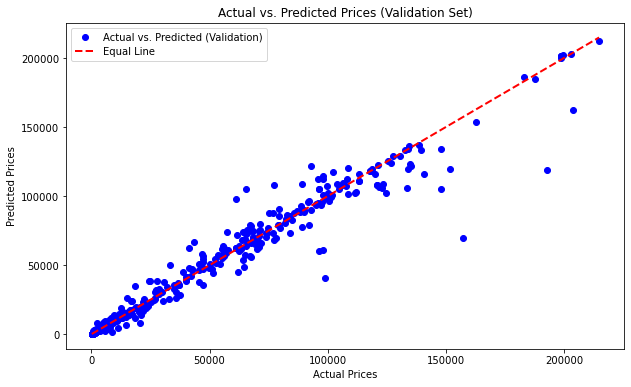

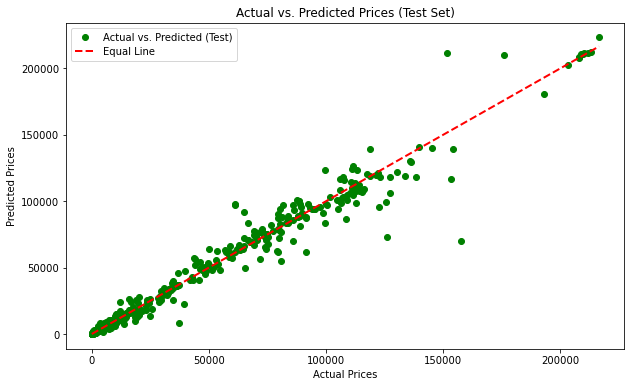

In [6]:
#step 5- visualize the pridictions
#the closer the points are to the lines the accurate our pridictions are!
import matplotlib.pyplot as plt
import numpy as np

y_val_pred = best_model.predict(X_val)
y_test_pred = best_model.predict(X_test)

# Validation set
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_val_pred, color='blue', label='Actual vs. Predicted (Validation)')
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], linestyle='--', color='red', linewidth=2, label='Equal Line')
plt.title('Actual vs. Predicted Prices (Validation Set)')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.legend()
plt.show()

# Test set
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, color='green', label='Actual vs. Predicted (Test)')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', linewidth=2, label='Equal Line')
plt.title('Actual vs. Predicted Prices (Test Set)')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.legend()
plt.show()
